In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
import pickle

from pymongo import MongoClient
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

## Connect to MongoDB - Get Spotify Data

In [2]:
client = MongoClient()
db = client.get_database('spotify')
db.list_collection_names()

['track_features', 'tracks', 'artists', 'albums', 'track_analysis']

In [3]:
cursor = db.track_features.find({}, {'_id': 0, 'duration_ms': 0,
                                     'time_signature': 0, 'tempo': 0,
                                     'mode': 0, 'key': 0})
track_features_df = pd.DataFrame(list(cursor))
track_features_df.rename(columns={'id': 'spotify_song_id'}, inplace=True)

## Grab the Genius Data and Merge

In [4]:
sentiment_features = pd.read_pickle('../Data/combined_sentiment_scores_df')
df = sentiment_features[['spotify_song_id', 'neg', 'neu', 'pos',
                         'compound', 'polarity', 'subjectivity']]

In [5]:
df = track_features_df.merge(df, on='spotify_song_id')

In [6]:
df.head(2)

,acousticness,album_uri,analysis_url,artist_uri,danceability,energy,spotify_song_id,instrumentalness,liveness,loudness,...,track_href,type,uri,valence,neg,neu,pos,compound,polarity,subjectivity
0,0.00834,spotify:album:4vQcWE7Ce6ORsatrqXkBtt,https://api.spotify.com/v1/audio-analysis/2dqp...,spotify:artist:14H7ag1wpQOsPPQJOD6Dqr,0.485,0.664,2dqpsVfEE3SWltmZ7UWb0m,0.57,0.120,-8.003,...,https://api.spotify.com/v1/tracks/2dqpsVfEE3SW...,audio_features,spotify:track:2dqpsVfEE3SWltmZ7UWb0m,0.742,0.0,0.835,0.165,0.7579,-0.060606,0.242424
1,0.51800,spotify:album:4vQcWE7Ce6ORsatrqXkBtt,https://api.spotify.com/v1/audio-analysis/3C6f...,spotify:artist:14H7ag1wpQOsPPQJOD6Dqr,0.331,0.412,3C6fiZI9I8xEMbUSfXfQCD,0.23,0.131,-8.576,...,https://api.spotify.com/v1/tracks/3C6fiZI9I8xE...,audio_features,spotify:track:3C6fiZI9I8xEMbUSfXfQCD,0.246,0.0,0.678,0.322,0.8966,0.004167,0.518452


## Separate Features Columns from other data

In [7]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

In [8]:
features = df.select_dtypes(include=numerics)
no_features = df.select_dtypes(exclude=numerics)

In [9]:
ss = StandardScaler()
scaled_features = ss.fit_transform(features)
scaled_features = pd.DataFrame(scaled_features)
scaled_features.columns = features.columns
track_features_df = pd.merge(no_features, scaled_features,
                             right_index=True, left_index=True)
track_features_df.rename(columns={'id': 'spotify_song_id'}, inplace=True)

## Checking Inertia

In [10]:
KMeans_df = track_features_df.select_dtypes(include=numerics)

inertia = []
i = 2
while i <= 30:
    num_clusters = i
    km = KMeans(n_clusters=num_clusters, n_jobs=-1, n_init=10)
    km.fit(KMeans_df.values)
    inertia.append(km.inertia_)
    i += 1

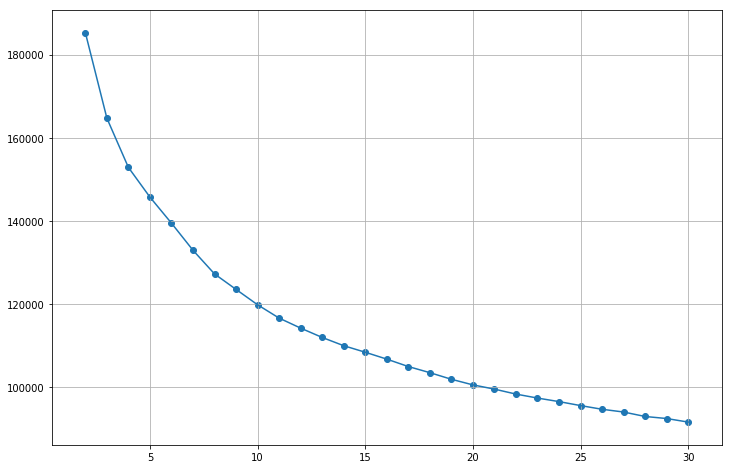

In [13]:
plt.figure(figsize=(12, 8))
plt.grid()
plt.plot(range(2, 31, 1), inertia)
plt.scatter(range(2, 31, 1), inertia)

In [14]:
km = KMeans(n_clusters=6, n_jobs=-1, n_init=10)
km.fit(KMeans_df.values)
inertia.append(km.inertia_)

In [15]:
corr_df = KMeans_df.corr()

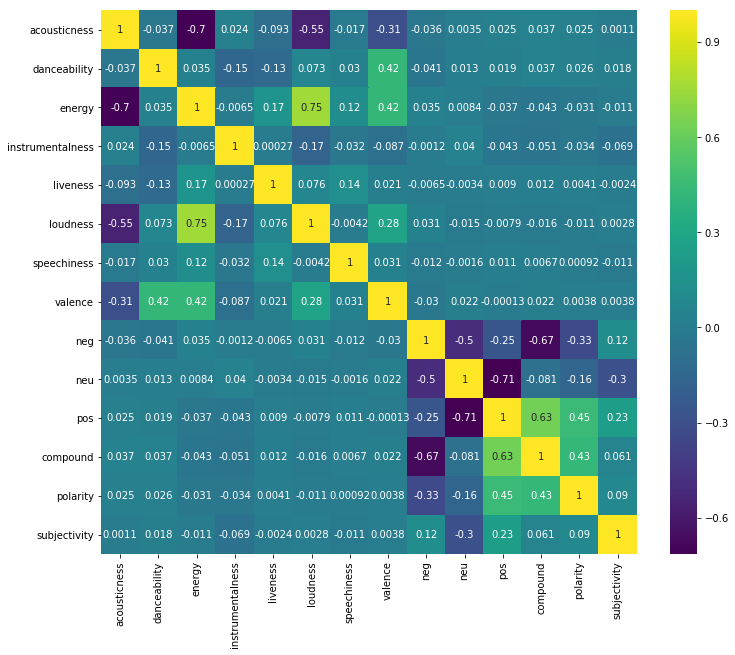

In [17]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_df, annot=True, cmap='viridis')

In [18]:
inertia = []
i = 2
while i <= 30:
    num_clusters = i
    km = KMeans(n_clusters=num_clusters, n_jobs=-1, n_init=10)
    km.fit(KMeans_df.values)
    inertia.append(km.inertia_)
    test = pd.DataFrame(km.cluster_centers_,
                        columns=KMeans_df.columns.tolist())
    print(test.apply(lambda x: x.argmin(), axis=1).value_counts(), '\n')
    print(pd.Series(km.labels_).value_counts(), '\n')
    i += 1

acousticness    1
energy          1
dtype: int64 

0    10099
1     5207
dtype: int64 



/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  if __name__ == '__main__':


acousticness    1
compound        1
energy          1
dtype: int64 

2    6863
0    4381
1    4062
dtype: int64 

neu         1
compound    1
neg         1
energy      1
dtype: int64 

3    4434
0    4108
2    3540
1    3224
dtype: int64 

danceability    1
compound        1
neu             1
neg             1
energy          1
dtype: int64 

0    4109
3    3869
1    3410
4    3028
2     890
dtype: int64 

neu             1
compound        1
loudness        1
danceability    1
neg             1
energy          1
dtype: int64 

2    3978
1    3560
3    3193
0    2891
5    1485
4     199
dtype: int64 

energy          2
neu             1
compound        1
loudness        1
danceability    1
neg             1
dtype: int64 

0    3765
2    3229
6    2647
1    2379
4    1724
5    1367
3     195
dtype: int64 

danceability    2
energy          2
neu             1
compound        1
loudness        1
neg             1
dtype: int64 

1    3535
0    3073
3    2529
2    2273
7    1672
6    1313
5

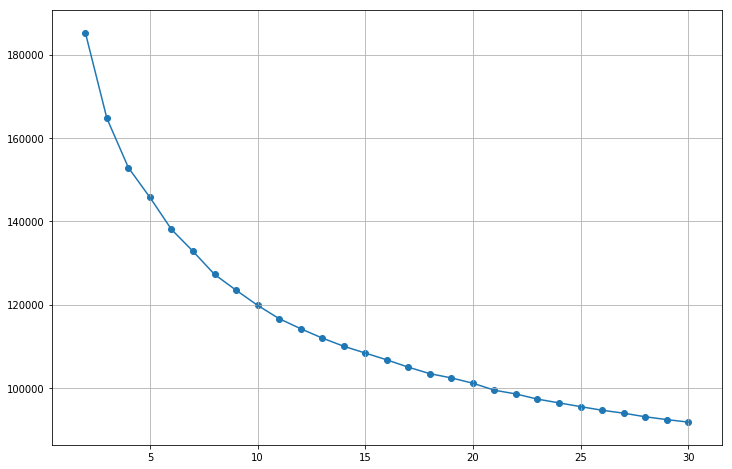

In [26]:
plt.figure(figsize=(12, 8))
plt.grid()
plt.plot(range(2, 31, 1), inertia)
plt.scatter(range(2, 31, 1), inertia)

Chose 11 clusters due to relatively even distribution of points to centroids and balanced of max feature across centroids

In [20]:
km = KMeans(n_clusters=11, n_jobs=-1, n_init=50)
km.fit(KMeans_df.values)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=11, n_init=50, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [21]:
km.labels_

array([6, 2, 8, ..., 4, 5, 6], dtype=int32)

In [22]:
df = (track_features_df.merge(
    pd.DataFrame(km.labels_, columns=['labels']),
    left_index=True,right_index=True)

In [23]:
df.to_pickle('../Data/labeled_points')

In [24]:
df.head()

,album_uri,analysis_url,artist_uri,spotify_song_id,track_href,type,uri,acousticness,danceability,energy,...,loudness,speechiness,valence,neg,neu,pos,compound,polarity,subjectivity,labels
0,spotify:album:4vQcWE7Ce6ORsatrqXkBtt,https://api.spotify.com/v1/audio-analysis/2dqp...,spotify:artist:14H7ag1wpQOsPPQJOD6Dqr,2dqpsVfEE3SWltmZ7UWb0m,https://api.spotify.com/v1/tracks/2dqpsVfEE3SW...,audio_features,spotify:track:2dqpsVfEE3SWltmZ7UWb0m,-0.890761,-0.154422,0.228150,...,0.117052,-0.391855,1.152411,-1.323306,1.360642,-0.449550,0.568894,-0.772440,-1.531799,6
1,spotify:album:4vQcWE7Ce6ORsatrqXkBtt,https://api.spotify.com/v1/audio-analysis/3C6f...,spotify:artist:14H7ag1wpQOsPPQJOD6Dqr,3C6fiZI9I8xEMbUSfXfQCD,https://api.spotify.com/v1/tracks/3C6fiZI9I8xE...,audio_features,spotify:track:3C6fiZI9I8xEMbUSfXfQCD,0.690413,-1.179836,-0.861343,...,-0.037373,-0.434470,-0.875575,-1.323306,0.285321,0.749032,0.754072,-0.438743,0.169808,2
2,spotify:album:4vQcWE7Ce6ORsatrqXkBtt,https://api.spotify.com/v1/audio-analysis/0gBT...,spotify:artist:14H7ag1wpQOsPPQJOD6Dqr,0gBTPgvzYPMPbYlTuPjx9n,https://api.spotify.com/v1/tracks/0gBTPgvzYPMP...,audio_features,spotify:track:0gBTPgvzYPMPbYlTuPjx9n,1.493938,0.344968,-1.029955,...,-0.862051,-0.479022,-0.245918,0.077850,1.278452,-1.487812,-1.684616,-0.301692,0.245737,8
3,spotify:album:4vQcWE7Ce6ORsatrqXkBtt,https://api.spotify.com/v1/audio-analysis/0QvF...,spotify:artist:14H7ag1wpQOsPPQJOD6Dqr,0QvF5Q3dg3TpRsU6Wqz9EV,https://api.spotify.com/v1/tracks/0QvF5Q3dg3Tp...,audio_features,spotify:track:0QvF5Q3dg3TpRsU6Wqz9EV,-0.277539,-1.293031,-0.601940,...,0.030541,-0.296941,-1.663464,-0.499653,-1.159855,1.695683,0.885178,1.117267,-0.040743,2
4,spotify:album:4vQcWE7Ce6ORsatrqXkBtt,https://api.spotify.com/v1/audio-analysis/3G5q...,spotify:artist:14H7ag1wpQOsPPQJOD6Dqr,3G5qMSP9AywIErX4HSbP5a,https://api.spotify.com/v1/tracks/3G5qMSP9AywI...,audio_features,spotify:track:3G5qMSP9AywIErX4HSbP5a,-0.578473,0.617967,-0.377124,...,0.054797,-0.479022,-0.617988,1.516874,-0.694111,-0.441916,-1.684616,-0.123910,1.331789,1


In [25]:
pickle_out = open('../Data/kmeans_cluster_centers_11', 'wb')
pickle.dump(km.cluster_centers_, pickle_out)
pickle_out.close()

In [ ]:
from sklearn.metrics.pairwise_distances

In [70]:
from sklearn.cluster import DBSCAN

In [127]:
dbs = DBSCAN(metric='minkowski',p=1,n_jobs=-1, eps=8,min_samples=100)

In [128]:
dbs.fit(KMeans_df)

DBSCAN(algorithm='auto', eps=8, leaf_size=30, metric='minkowski',
    metric_params=None, min_samples=100, n_jobs=-1, p=1)

In [129]:
pd.Series(dbs.labels_).value_counts()

 0    18244
-1      436
dtype: int64

In [138]:
from sklearn.cluster import mean_shift

In [140]:
KMeans_df.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,neg,neu,pos,compound,polarity,subjectivity
0,-0.889816,-0.150869,0.237184,1.672013,-0.462822,0.146473,-0.392443,1.159519,-1.319268,1.358555,-0.450702,0.564429,-0.768552,-1.536352
1,0.694877,-1.178074,-0.849247,0.364668,-0.392596,-0.004912,-0.434665,-0.865222,-1.319268,0.284414,0.737061,0.749197,-0.436594,0.166627
2,1.500189,0.349394,-1.017385,0.314682,-0.571353,-0.813355,-0.478806,-0.236572,0.085411,1.276455,-1.479591,-1.684092,-0.300256,0.242617
3,-0.275229,-1.291467,-0.590573,1.579730,-0.558584,0.061666,-0.298402,-1.651850,-0.493545,-1.159177,1.675167,0.880013,1.111310,-0.044095
4,-0.576832,0.622871,-0.366389,-0.492719,-0.462822,0.085444,-0.478806,-0.608047,1.528054,-0.693944,-0.443136,-1.684092,-0.123401,1.329544


In [143]:
test = np.random.normal(size=1000).reshape(100,10)

In [147]:
test = mean_shift(np.array(KMeans_df), min_bin_freq=5,cluster_all=False,n_jobs=-1)

In [151]:
pd.Series(test[1]).value_counts()

 0     14959
-1      3682
 1        14
 2         9
 3         2
 6         1
 16        1
 17        1
 4         1
 5         1
 15        1
 8         1
 9         1
 10        1
 11        1
 12        1
 13        1
 14        1
 7         1
dtype: int64

In [155]:
from sklearn.cluster import AgglomerativeClustering

In [11]:
from sklearn.cluster import DBSCAN
import numpy as np

In [17]:
for i in np.linspace(1.05, 1.26, 100):
    dbs = DBSCAN(eps=i, min_samples=30, n_jobs=-1)
    dbs.fit(KMeans_df)
    print(i)
    print(pd.Series(dbs.labels_).value_counts())
    print()

1.05
-1    15306
dtype: int64

1.0521212121212122
-1    15306
dtype: int64

1.0542424242424242
-1    15306
dtype: int64

1.0563636363636364
-1    15306
dtype: int64

1.0584848484848486
-1    15306
dtype: int64

1.0606060606060606
-1    15306
dtype: int64

1.0627272727272727
-1    15306
dtype: int64

1.064848484848485
-1    15306
dtype: int64

1.066969696969697
-1    15306
dtype: int64

1.069090909090909
-1    15306
dtype: int64

1.0712121212121213
-1    15306
dtype: int64

1.0733333333333335
-1    15306
dtype: int64

1.0754545454545454
-1    15306
dtype: int64

1.0775757575757576
-1    15306
dtype: int64

1.0796969696969698
-1    15306
dtype: int64

1.0818181818181818
-1    15306
dtype: int64

1.083939393939394
-1    15306
dtype: int64

1.0860606060606062
-1    15306
dtype: int64

1.0881818181818181
-1    15306
dtype: int64

1.0903030303030303
-1    15306
dtype: int64

1.0924242424242425
-1    15306
dtype: int64

1.0945454545454545
-1    15306
dtype: int64

1.0966666666666667
-1    153

In [ ]:
inertia = []
i = 2
while i <= 30:
    num_clusters = i
    ac = AgglomerativeClustering(n_clusters=num_clusters)
    ac.fit(KMeans_df.values)
    ac.
    i += 1

In [ ]:
plt.figure(figsize=(12,8))
plt.grid()
plt.plot(range(2,31,1),inertia)
plt.scatter(range(2,31,1),inertia)

In [154]:
from sklearn.cluster import affinity_propagation

In [ ]:
affinity_propagation()